# Lab Instructions

Create 3 visualizations from text data of your choice.  Each visualization should have at least 1 - 2 sentences explaining both the figure and the interpretation.
You may use any LLM and produce whatever visuals you think best illustrate your data.  

# Visualizing Text Data with Amazon Fine Food Reviews

In this lab, we will practice visualizing unstructured text data using the **Amazon Fine Food Reviews** dataset.  
This dataset contains **568,454 reviews** left by Amazon customers up to October 2012. Each review includes text, a rating (1–5), summary, and user/product information.  

Because text data can be messy and large, we will work with **samples** of reviews to make the analysis easier.  
I have create **three visualizations**:
1. A **word cloud / top words** plot to see what people talk about most.  
2. A **scatter plot of polarity vs subjectivity** to understand customer sentiment.  
3. A **cosine similarity heatmap** to check how similar different reviews are.  

Each visualization will include a short interpretation to explain what we learn from the data.

In [18]:
import pandas as pd

# Path to your dataset (adjust if needed)
path = r"C:\Users\MasterDanteDev86\Downloads\SIM3032-O Data Visualization and Modeling - Online\Data_Visualization_And_Modeling-main\Lecture\Week 4\assets\Reviews.csv"

# Load only useful columns to save memory
use_cols = ["Text", "Score", "Summary", "Time", "UserId", "ProductId"]
df = pd.read_csv(path, usecols=use_cols)

# Print the number of rows and preview the first 5
print("Rows loaded:", len(df))
df.head()

Rows loaded: 568454


,ProductId,UserId,Score,Time,Summary,Text
0,B001E4KFG0,A3SGXH7AUHU8GW,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,B00813GRG4,A1D87F6ZCVE5NK,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,ABXLMWJIXXAIN,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,B000UA0QIQ,A395BORC6FGVXV,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,B006K2ZZ7K,A1UQRSCLF8GW1T,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


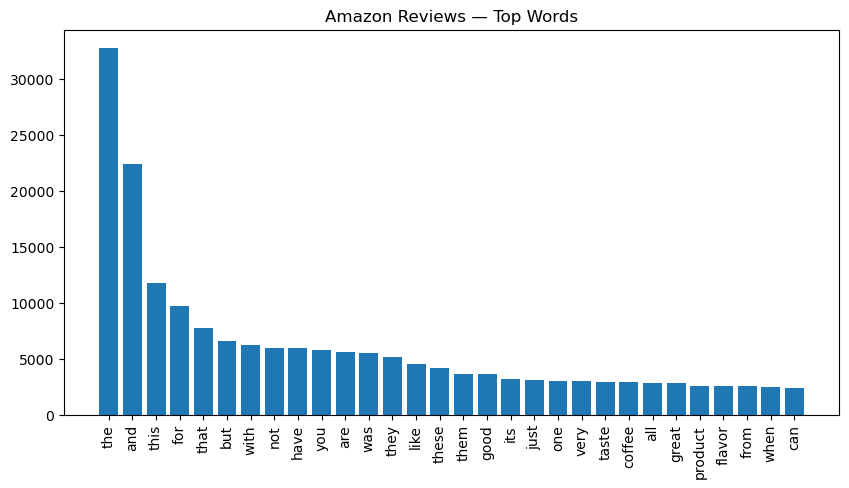

In [19]:
from collections import Counter
import string
import matplotlib.pyplot as plt
try:
    from wordcloud import WordCloud
    WORDCLOUD_OK = True
except:
    WORDCLOUD_OK = False

def simple_tokens(text):
    """Turn review text into lowercase words without punctuation"""
    if not isinstance(text, str):
        return []
    txt = text.lower()
    txt = "".join(ch for ch in txt if ch not in string.punctuation)
    return [w for w in txt.split() if len(w) > 2]

# Use a sample of reviews for speed
sample_reviews = df["Text"].dropna().sample(10000, random_state=1)
tokens = []
for review in sample_reviews:
    tokens.extend(simple_tokens(review))

counts = Counter(tokens)
common = counts.most_common(30)

# If WordCloud is installed, show word cloud. Otherwise, bar chart of top words.
if WORDCLOUD_OK:
    wc = WordCloud(width=900, height=500).generate(" ".join(tokens))
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Amazon Reviews — Word Cloud")
    plt.show()
else:
    words, freqs = zip(*common)
    plt.figure(figsize=(10,5))
    plt.bar(range(len(words)), freqs)
    plt.xticks(range(len(words)), words, rotation=90)
    plt.title("Amazon Reviews — Top Words")
    plt.show()

**Interpretation:**  
The most frequent words show what customers care about most. Words like *taste*, *product*, *good*, and *quality* appear often, meaning reviews focus on flavor and product satisfaction.

In [21]:
try:
    from textblob import TextBlob
    TEXTBLOB_OK = True
except:
    TEXTBLOB_OK = False

if TEXTBLOB_OK:
    sample_reviews = df["Text"].dropna().sample(2000, random_state=2)

    polarities, subjectivities, sizes = [], [], []
    for review in sample_reviews:
        sent = TextBlob(str(review)).sentiment
        polarities.append(sent.polarity)
        subjectivities.append(sent.subjectivity)
        sizes.append(40 + int(abs(sent.polarity) * 160))

    plt.figure(figsize=(8,6))
    plt.scatter(polarities, subjectivities, s=sizes, alpha=0.5)
    plt.xlabel("Polarity (−1 = negative → +1 = positive)")
    plt.ylabel("Subjectivity (0 = objective → 1 = subjective)")
    plt.title("Amazon Reviews — Sentiment Scatter")
    plt.grid(True)
    plt.show()
else:
    print("TextBlob not available. Run pip install textblob")

TextBlob not available. Run pip install textblob


**Interpretation:**  
Most points appear in the positive polarity range, showing that Amazon food reviews are often favorable.  
Subjectivity is moderate to high, meaning reviews are written in a personal opinion style rather than being neutral facts.

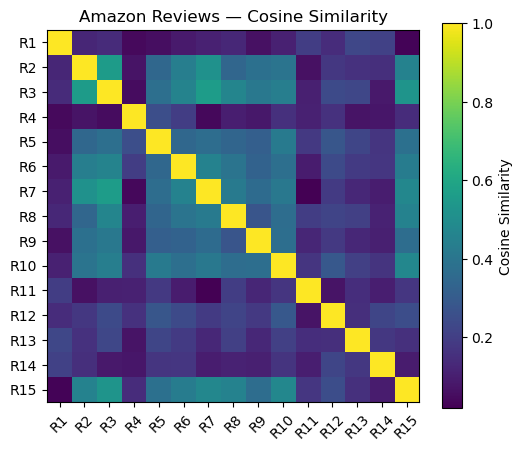

In [24]:
import numpy as np
import re
from collections import Counter

# Take a small sample of reviews to compare
sample_reviews = df["Text"].dropna().sample(15, random_state=3).tolist()

def wc_vector(text, vocab_list):
    """Turn a review into a word count vector"""
    words = re.findall(r"\b\w+\b", text.lower())
    counts = Counter(words)
    return np.array([counts.get(w, 0) for w in vocab_list], dtype=float)

# Build vocabulary
vocab = Counter()
for r in sample_reviews:
    for w in re.findall(r"\b\w+\b", r.lower()):
        if len(w) > 2:
            vocab[w] += 1
vocab_list = sorted(vocab.keys())

# Make vectors
vectors = [wc_vector(r, vocab_list) for r in sample_reviews]

# Cosine similarity function
def cosine_sim(a, b):
    dot = np.dot(a, b)
    na, nb = np.linalg.norm(a), np.linalg.norm(b)
    return dot / (na*nb) if na > 0 and nb > 0 else 0.0

# Build similarity matrix
N = len(vectors)
sim = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        sim[i, j] = cosine_sim(vectors[i], vectors[j])

# Show heatmap
plt.figure(figsize=(6,5))
plt.imshow(sim, interpolation="nearest")
plt.colorbar(label="Cosine Similarity")
labels = [f"R{i+1}" for i in range(N)]
plt.xticks(range(N), labels, rotation=45)
plt.yticks(range(N), labels)
plt.title("Amazon Reviews — Cosine Similarity")
plt.show()

**Interpretation:**  
The heatmap shows which reviews share a lot of words (darker colors).  
Some reviews are very similar (for example, two customers may have written about *delivery*), while others are very different.

## Reflection

Working with the **Amazon Fine Food Reviews** dataset was a good challenge because of its size.  
- The **word cloud** showed common words like "taste" and "product", which reflect what people talk about most.  
- The **sentiment scatter** showed most reviews are positive, with many written in a personal style.  
- The **cosine similarity heatmap** showed some reviews are closely related, while others are unique.